# Masters Dissertation - Advent Insurance Management - Facilitiating Same-Day Settlement and Fraud Detection with ML

## Import required libaries 

In [155]:
import pandas as pd 
import numpy as np 
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import svm, preprocessing, metrics
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_auc_score 

 ## Define function to import data and merge datasets 

In [2]:
# Create function to import data and drop duplicated data from each df 
# Import data (you manually dropped the first two lines from the excel file in excel in order to capture the 
# header information)
# Note primary keys: Catastrophe Name (dive_assure), ID (Policy)
def import_data():
    """Function to import both the Policy and DiveAssure datasets and drop duplicates, with both file paths already 
    inside function - NOTE thiswill not work on another computer or file location, paths must updated"""
    dive_assure = pd.read_excel(r'C:\Users\Home\OneDrive\Advent\LloydsBordereauV5-J.xlsx')
    policy = pd.read_csv(r'C:\Users\Home\OneDrive\Advent\PolicyInfoLloydsBordereau.csv')
    # Drop duplicate data from dfs
    dive_assure = dive_assure.drop_duplicates(subset='Catastrophe Name')
    policy = policy.drop_duplicates(subset='ID')
    # Change colname of dive_assure from Catastrophe Name to ID for merge 
    dive_assure = dive_assure.rename(columns={'Catastrophe Name': 'ID'})
    # Change ID type to string and drop decimal 
    policy['ID'] = policy['ID'].astype(str).apply(lambda x: x.replace('.0',''))
    # Change ID in dive to str 
    dive_assure['ID'] = dive_assure['ID'].astype(str)
    # Merge dfs
    df = pd.merge(policy, dive_assure, on='ID', sort=False, how='left')
    return df

In [175]:
# A function to get names of features  
def col_names(df):
    """pass both df's and will return feature names for each df"""
    df_colnames = df.columns 
    return df_colnames

# Begin Cleaning the Data

In [21]:
# Change cell settings to display all rows 
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [5]:
# A function to identiy features wuth values <= 1 and drop them from the df 
def drop_low_info_cols(df):
    """Takes features with no or little unique values and drops them from df"""
    # Create dict object of unique values for df 
    uniques = dict(df.nunique())

    # Which features have <= 1 value 
    features_to_delete = [] # store values 
    for k,v in uniques.items():
        if v <= 1:
            features_to_delete.append(k)
    #drop columns from features_to_delete list
    for i in features_to_delete:
        df = df.drop([i], axis = 1)
    return df 

In [ ]:
# Function to drop features with little information gain such as name, or features that are added during the claims 
# handling process and would therefore be unavilable at the point of running the script
def drop_features(df):
    """Pass df and will drop relevant features"""
    df = df.drop(['Certificate Reference',
           'Claim Reference / Number', 'Insured Full Name or Company Name',
           'Loss Description', 'Claim Status', 'Refer to Underwriters', 'Loss Description',
           'Paid this month - Indemnity', 'Paid this month - Fees',
           'Previously Paid - Indemnity', 'Previously Paid - Fees',
           'Reserve - Indemnity', 'Reserve - Fees',
           'Change this month - Indemnity', 'Change this month - Fees',
           'Total Incurred - Indemnity', 'Total Incurred - Fees', 'Date Closed',
           'Paid this month - Expenses', 'Claimant Name',
           'Paid this month - Adjusters Fees', 'Paid this month - TPA Fees',
           'Previously Paid - Expenses', 'Previously Paid - Adjusters Fees',
           'Previously Paid - TPA Fees',
           'Reserve - TPA Fees', 'Total Incurred',
           'Date Claims Paid (Final)', 'Date Fees Paid (Final)', 'Date Reopened',
           'Claim First Notification Acknowledgement Date',
           'Date First Reserve Established', 'Peer review date','Rate of Exchange', 
           'Location of loss State, Province, Territory, Canton', 'Transaction ID', 'Created By',
           'Registration Type', 'Address 1', 'Email', 'First Name', 'Last Name'], axis=1)
    # drop rows where label = NaN
    df = df.dropna(subset=['Denial', 'Creation Date'])
    # Change NaNs and NaTs to 0 of remaining features 
    df = df.fillna(0)
    return df 

In [6]:
# # Reset cell display settings 
# pd.reset_option("display.max_rows")
# # pd.reset_option("display.max_columns")
# # Display df 
# df

In [7]:
# # Assess unique values and feature 
# # Create dict object of unique values for df 
# uniques_1 = dict(df.nunique())

# # Show number of unique values
# for k,v in uniques_1.items():
#         print(k, v)

# EDA and visualisation

In [632]:
# Import data for EDA 
df_eda = import_data()

In [633]:
df_city = pd.DataFrame(df_eda['City'])

In [634]:
# Function to drop additional cols which make no sense to visualise ie Dates etc 
def drop_for_vis(df):
    """Pass df and drop additional features for visualisation"""
    df = df.drop(['Creation Date', 'Risk Inception Date', 'Risk Expiry Date', 'Date Claim First Advised/Date Claim Made', 
                 'Date Claim Opened', 'From', 'To', 'Date of Loss (From)', 'Zip', 'ID', 'City'], axis=1)
    # Change from object to datetime
    df['Date of Birth'] = df['Date of Birth'].apply(pd.to_datetime)
    # Change structure og datetime object
    df['Date of Birth'] = (pd.to_datetime('now') - df['Date of Birth']).astype('<m8[Y]')
    # Rename column
    df.rename(columns={'Date of Birth': 'Years of Age'}, index={'Date of Birth': 'Years of Age'}, inplace=True)
#     df['City'] = df['City'].astype('str')
#     df['City'] = df['City'].str.replace(r"-"," ")
    cols = ['Cause of Loss Code', 'Lloyd\'s Cat Code', 'Insured State, Province, Territory, Canton etc.']
    df[cols] = df[cols].replace({0:'Unknown', '0':'Unknown', '07-Jul': 'A'})
    df['Is Secondary'] = df['Is Secondary'].astype(str)
    df['Main Member Non-Diving'] = df['Main Member Non-Diving'].astype(str)
    return df 

In [635]:
# Drop unwanted features from df 
df_eda = drop_low_info_cols(df_eda).pipe(drop_features).pipe(drop_for_vis)

array([[<AxesSubplot:title={'center':'Years of Age'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

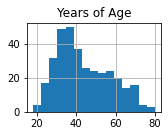

In [636]:
# Show histograms of numerical variables
df_eda.hist(bins=15, figsize=(18,8), layout=(4,6))

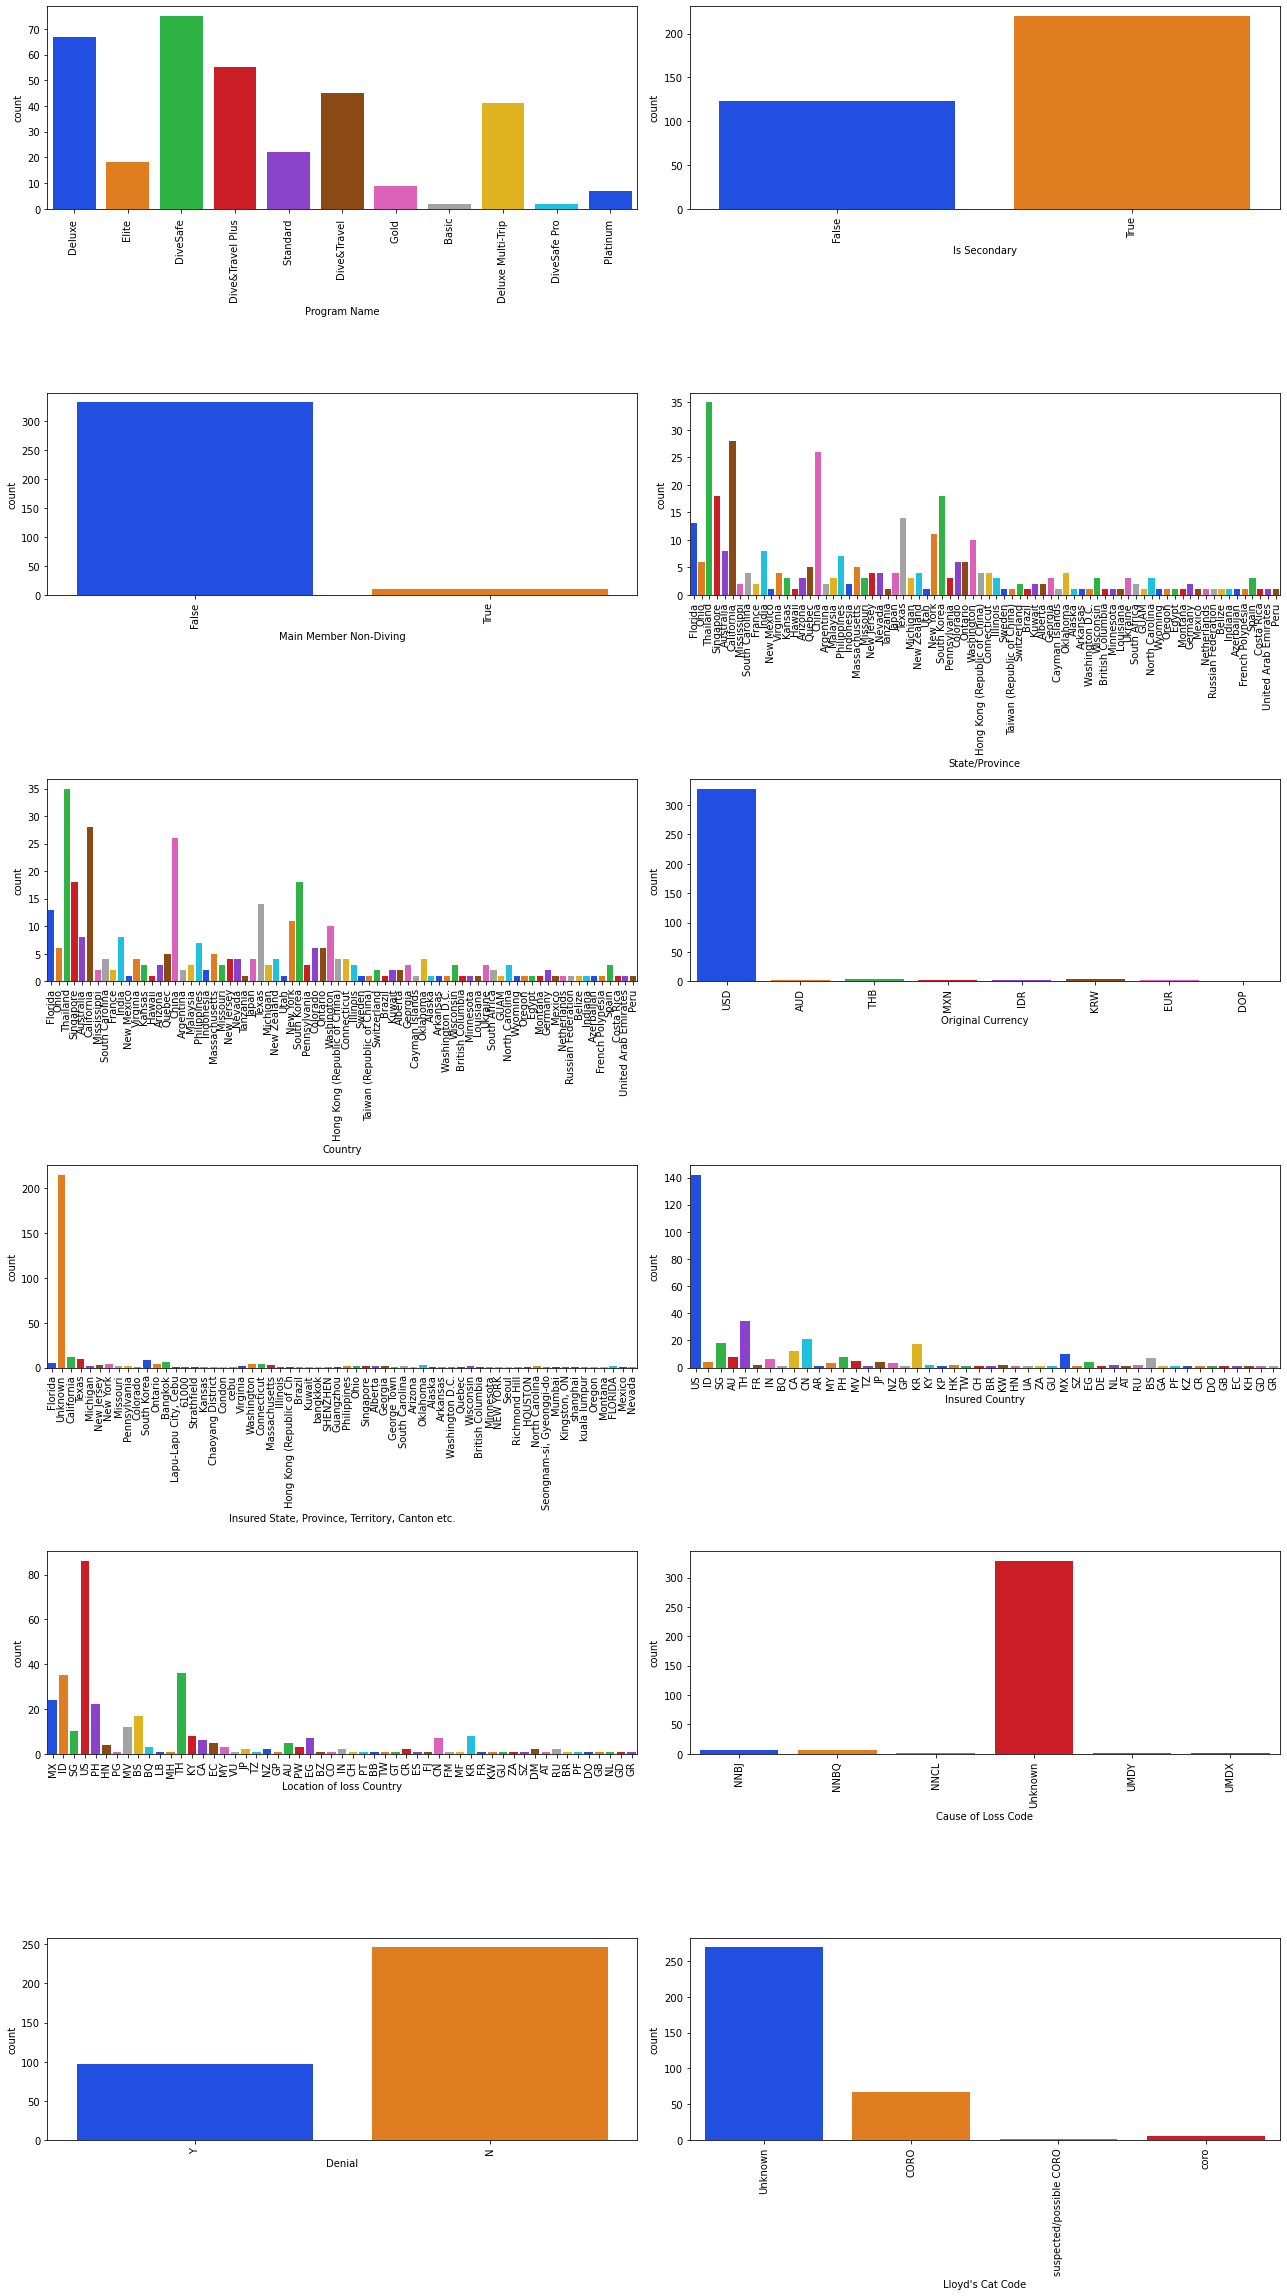

In [437]:
# Display all categorical features using bar plots 
import matplotlib.pyplot as plt
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

categorical=[]
for column in df_eda:
    if is_string_dtype(df_eda[column]):
        categorical.append(column)


fig, ax = plt.subplots(6, 2, figsize=(18, 32))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(df_eda[variable], ax=subplot, palette='bright')
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
fig.tight_layout()

In [430]:
# Change cell settings to display all rows 
# pd.set_option("display.max_rows", None)
# pd.set_option("display.max_columns", None)
pd.reset_option("display.max_rows")

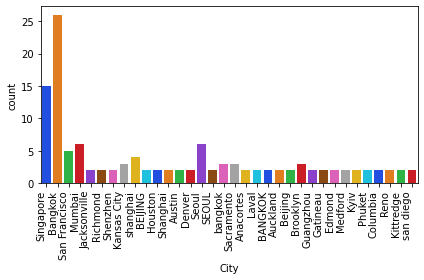

In [611]:
# Visualise city feature with droped cities that only appear once
counts = dict(df_city.value_counts())
significants = []
insignificants = []

# Which features have > 1 value 
features_to_delete = [] # store values 
for k,v in counts.items():
    if v > 1:
        significants.append(k)
    else:
        insignificants.append(k)
        
significants = pd.DataFrame(significants)[0].str.replace("(", "").str.replace("'", "").str.replace(",", "").str.replace(")", "")
significants = list(significants)
df_a = df_city[df_city['City'].isin(significants)]

a = sns.countplot(df_a['City'], palette='bright')
a.set_xticklabels(a.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

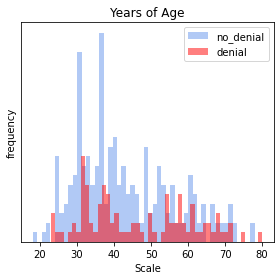

In [672]:
# Create histograms of numeric features with cases of fraud/no fraud highlighted 

# numeric col names 
column_name=['Years of Age']
# encode = preprocessing.LabelEncoder()
# df_eda[['Denial']] = df_eda[['Denial']].apply(encode.fit_transform)


# create df using numeric cols 
df_hist = df_eda.loc[:, [c for c in df_eda if c in column_name]]
# add target variable to df 
df_hist['Denial'] = df_eda['Denial']
# drop target and convert to array
data_array = np.array(df_hist)[:,0:-1]

# create df's with all rows of Denial/No Denial, then convert to arrays 
fig, ax = plt.subplots(figsize=(4,4))
no_denial1 = df_hist.loc[df_hist['Denial'] == 'N']
no_denial = np.array(no_denial1)[:,0:-1]
denial1 = df_hist.loc[df_hist['Denial'] == 'Y']
denial = np.array(denial1)[:,0:-1]


ax.hist(no_denial, bins=50, color='cornflowerblue', alpha=.5)
ax.hist(denial, bins=50, color='red', alpha=.5)
ax.set_title(column_name[i])
ax.set_yticks(())
ax.set_xlabel("Scale")
ax.set_ylabel("frequency")
ax.legend(["no_denial", "denial"], loc="best")
fig.tight_layout()

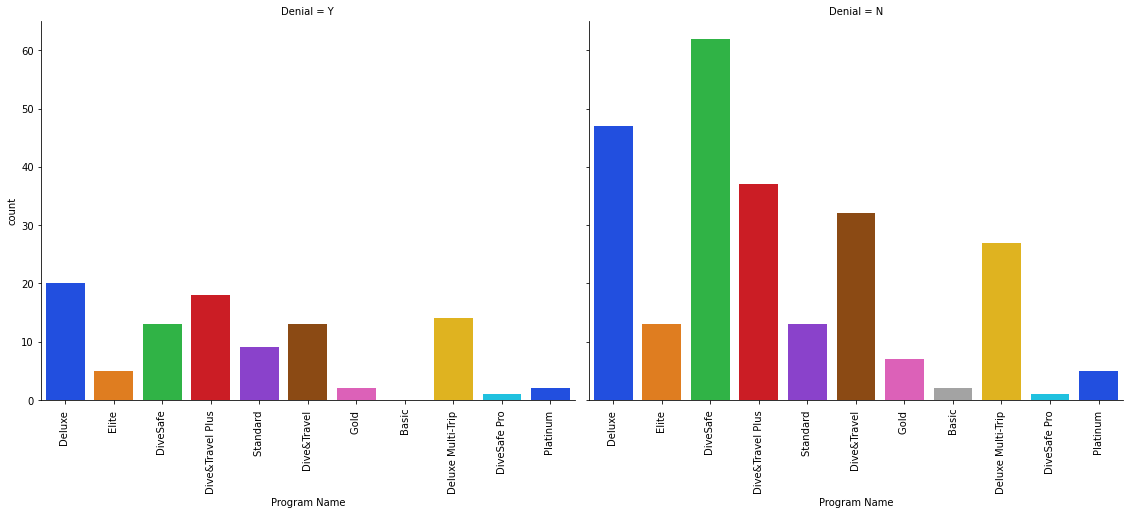

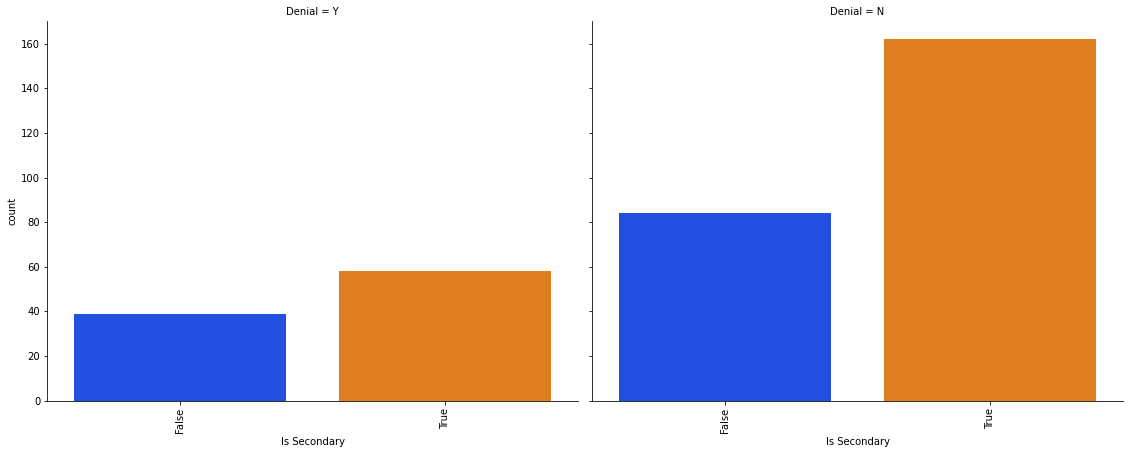

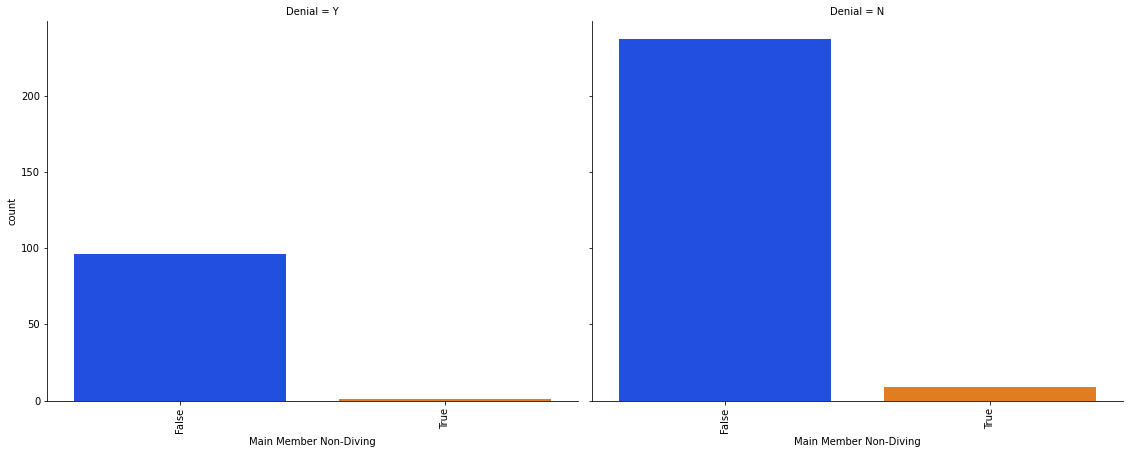

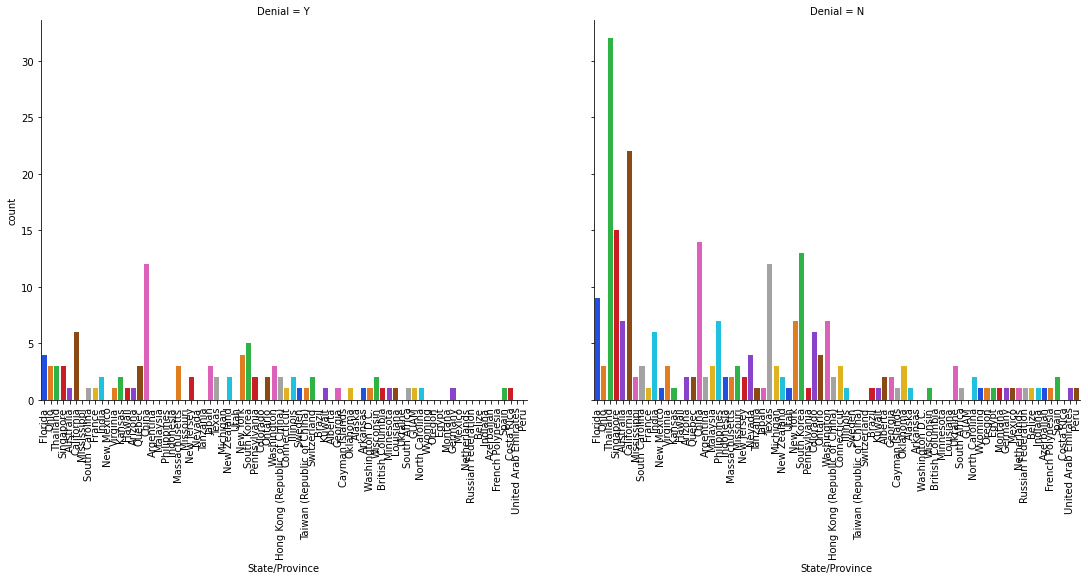

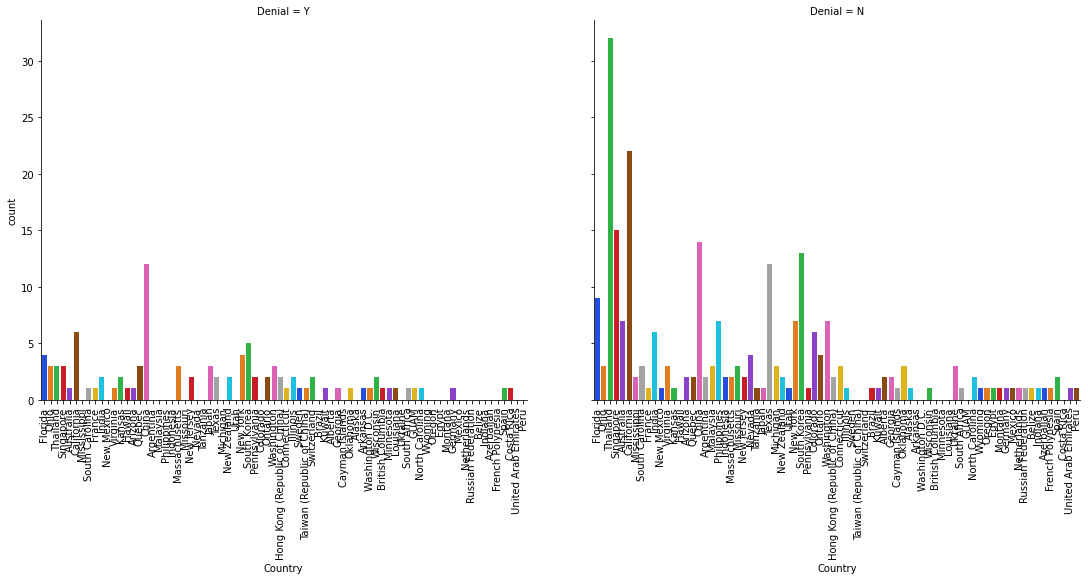

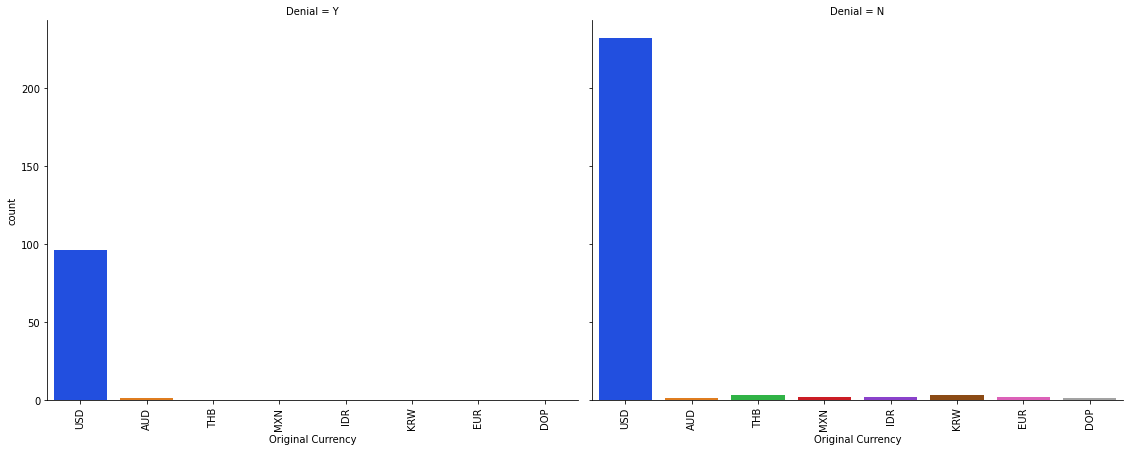

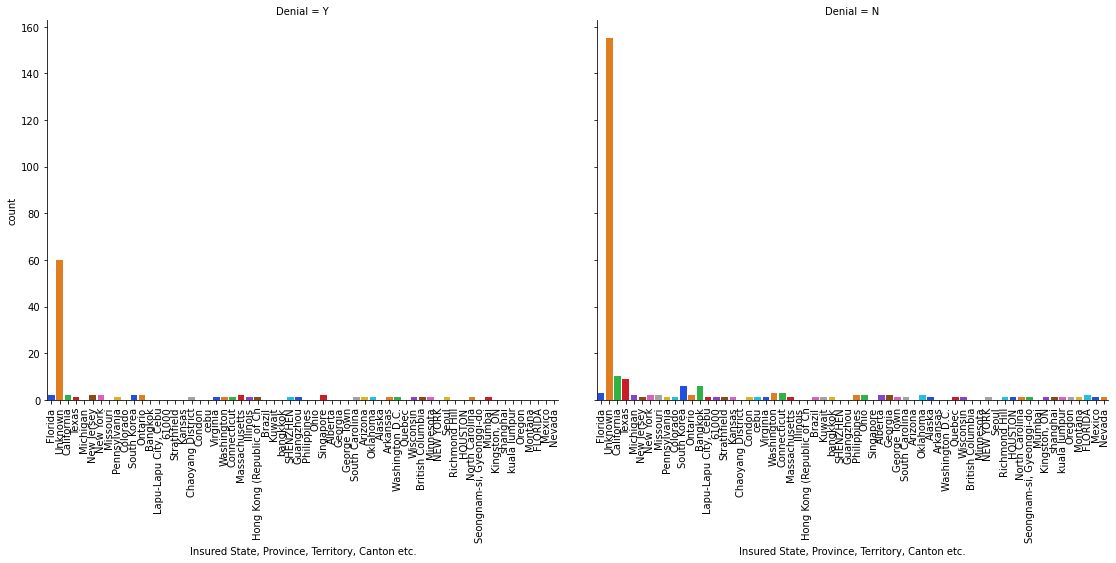

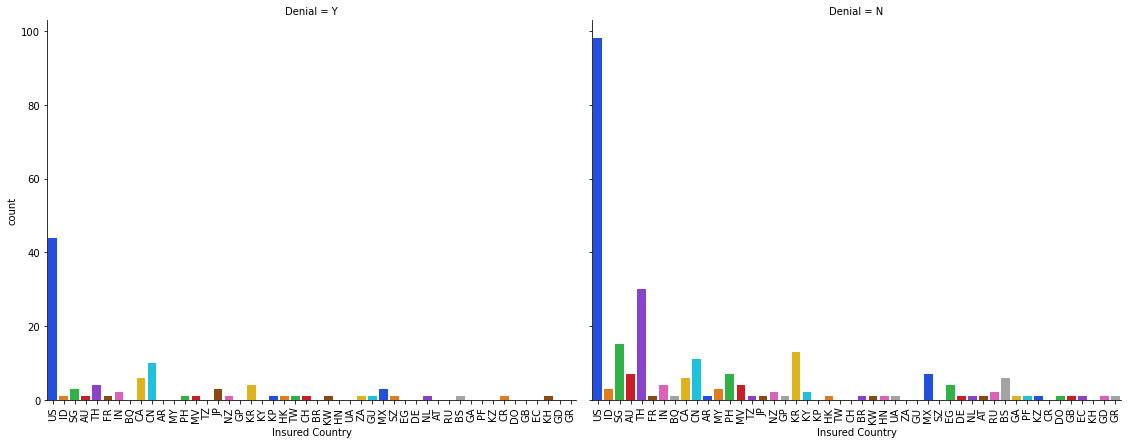

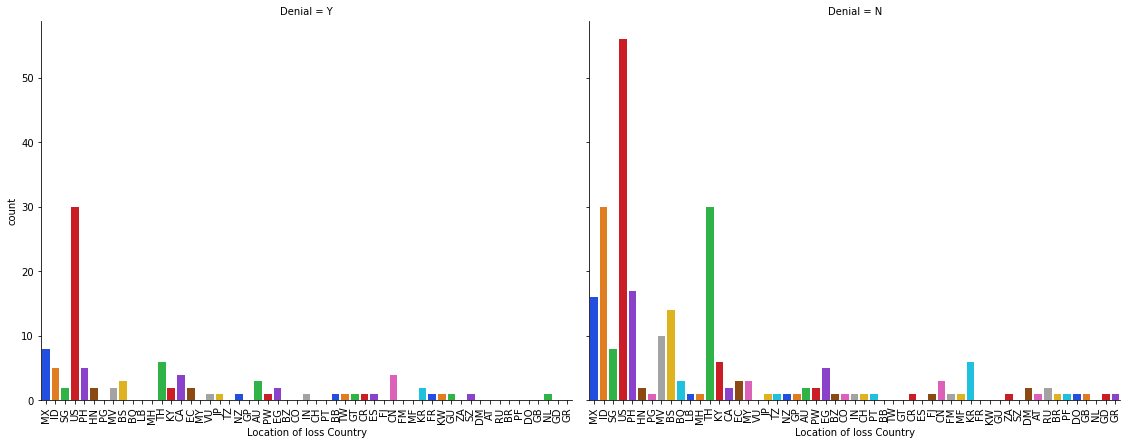

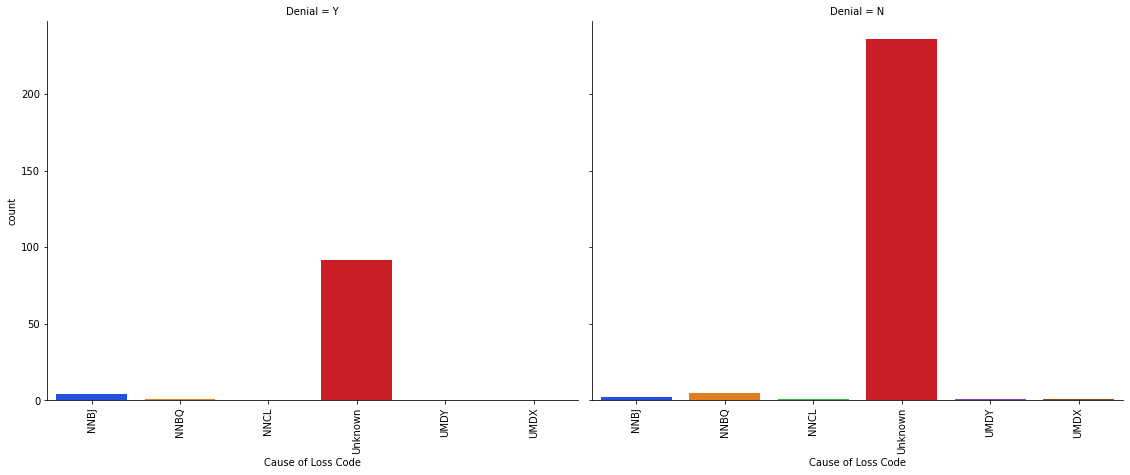

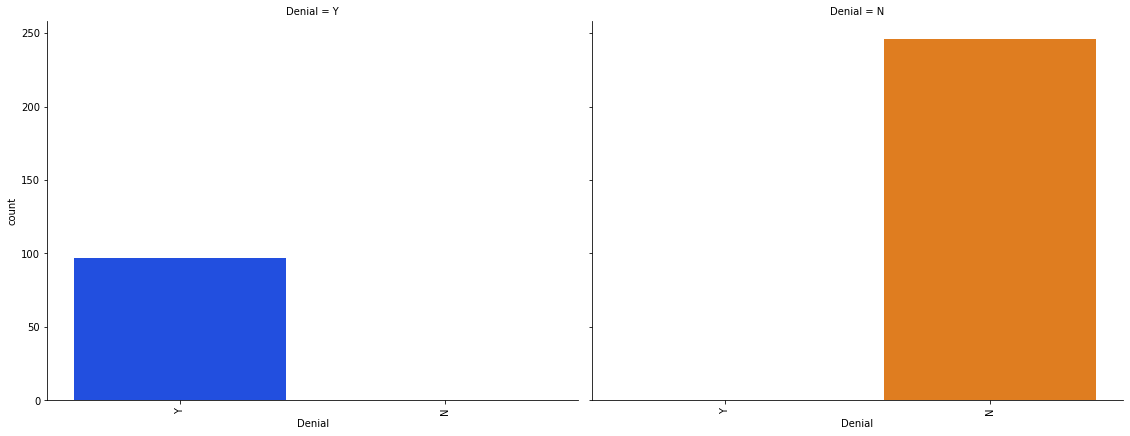

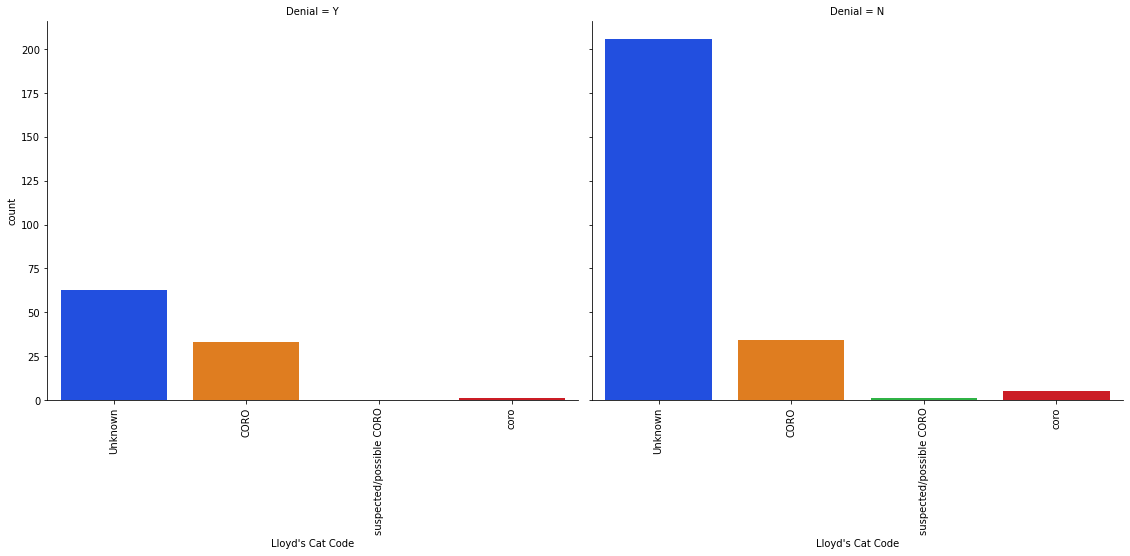

In [673]:
# Create bar plots using seaborn catplot highlighting Denial/No Denial differences

df_denial = df_eda[df_eda['Denial'] == 'Y']
df_no_denial = df_eda[df_eda['Denial'] == 'N']

for variable in categorical:
    plot = sns.catplot(x=variable, col="Denial", data=df_eda, kind='count',height=6, aspect=1.3, palette = 'bright')
    plot.set_xticklabels(rotation=90)
fig.tight_layout()

<AxesSubplot:xlabel='Denial', ylabel='count'>

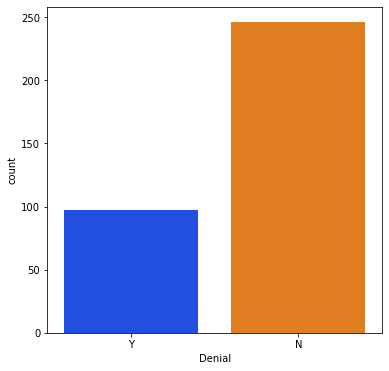

In [674]:
# Examine target varible 
plt.figure(figsize=(6,6))
sns.countplot(x = 'Denial', data = df_eda, palette = 'bright')

In [675]:
len(df_eda)

343

# Preprocessing 

In [676]:
# Function to clean certain features of the data and to label encode relevant features
def encode(df):
    """Takes df, cleans and applies label encoding """
    # Convert DOB from string to date_time object 
    cols = ['Date of Birth', 'Creation Date', 'From', 'To']
    df[cols] = df[cols].apply(pd.to_datetime)
    # Convert DOB from yyyy-mm-dd to years 
    df['Date of Birth'] = (pd.to_datetime('now') - df['Date of Birth']).astype('<m8[Y]')
    # Drop time stamp from Creation date 
    df['Creation Date'] = pd.to_datetime(df['Creation Date']).dt.date
    df['Creation Date'] = pd.to_datetime(df['Creation Date'])
    
    # Change type of city feature 
    df['City'] = df['City'].astype('str')

    #Change int and random value == random str
    cols = ['City', 'Cause of Loss Code', 'Lloyd\'s Cat Code', 'Insured State, Province, Territory, Canton etc.']
    df[cols] = df[cols].replace({0:'A', '0':'A', '07-Jul': 'A'})


    encode = preprocessing.LabelEncoder()
    df[['Program Name', 'Is Secondary', 'Main Member Non-Diving', 'State/Province', 'Country',
       'Original Currency', 'Location of loss Country', 'Insured Country', 'Denial', 
       'City', 'Cause of Loss Code', 'Lloyd\'s Cat Code',
       'Insured State, Province, Territory, Canton etc.']] = df[['Program Name', 
                                                                 'Is Secondary', 
                                                                 'Main Member Non-Diving', 
                                                                 'State/Province',
                                                                 'Country',
                                                                 'Original Currency',
                                                                 'Location of loss Country',               
                                                                 'Insured Country',
                                                                 'Denial',
                                                                 'City', 
                                                                 'Cause of Loss Code', 
                                                                 'Lloyd\'s Cat Code',
                                                                 'Insured State, Province, Territory, Canton etc.'
                                                                 ]].apply(encode.fit_transform)
    return df

In [11]:
# Check all NaNs have been removed/converted 
# df.isnull().sum()

In [12]:
# View data types
# df.dtypes

# Use dates to extract meaning about claim 

In [13]:
# Create function to use policy date infromation to return numbers of days or if claim is made within covered period
def use_dates(df):
    """Pass df and will return df with dates used to create count days, will drop orginal dates"""
    # Total days from policy taken out (creation date) to DOL (date of loss) 
    df['Total days from policy taken to DOL'] = (df['Date of Loss (From)']-df['Creation Date']).dt.days
    # Total number of days from DOL to (date claim first advised/date claim made) 
    df['Total days from DOL to claim made'] = (df['Date Claim First Advised/Date Claim Made']-df['Date of Loss (From)']).dt.days
    # Check DOL is within timeframe (From-To) 
    df['Is DOL in policy period'] = df['Date of Loss (From)'].between(df['From'],df['To']).astype(int)
    # Change 0's back to floating point numbers 
    df.ID = pd.to_numeric(df.ID, errors='coerce').fillna(0).astype(np.int64)
    df.Zip = pd.to_numeric(df.Zip, errors='coerce').fillna(0).astype(np.int64)
    df = df.drop(['Risk Inception Date','Risk Expiry Date', 'Date of Loss (From)', 
              'Creation Date', 'Date Claim First Advised/Date Claim Made', 'Date Claim Opened',
             'From', 'To', 'Date of Birth', 'ID', 'Zip'], axis=1)
    return df 

In [756]:
# Total number of days from (date claim first advised/date claim made) to (date claim opened)
# df['Total days from first advised-claim made'] = (df['Date Claim Opened']-df['Date Claim First Advised/Date Claim Made']).dt.days

In [695]:
# Function to get_dummies 

# def function for get dummies few
def get_dummies_few(df):
    """Function to create dummy variable for cols, pass df """
    # Create cols list for get_dummies func
    cols = ['Program Name', 'Original Currency', 'Cause of Loss Code', 'Lloyd\'s Cat Code']
    df = pd.get_dummies(data=df, columns=cols)
    return df 

# def function for get dummies all
def get_dummies_all(df):
    """Function to create dummy variable for cols, pass df """
    # Create cols list for get_dummies func
    cols = ['Program Name', 'Is Secondary', 'Main Member Non-Diving',
       'State/Province', 'City', 'Country', 'Original Currency',
       'Insured State, Province, Territory, Canton etc.', 'Insured Country',
       'Location of loss Country', 'Cause of Loss Code', 'Denial',
       'Lloyd\'s Cat Code', 'Total days from policy taken to DOL',
       'Total days from DOL to claim made', 'Is DOL in policy period']
    df = pd.get_dummies(data=df, columns=cols)
    return df

# Run functions and return df 

In [698]:
df = import_data().pipe(drop_low_info_cols).pipe(drop_features).pipe(encode).pipe(use_dates)

In [699]:
df

,Program Name,Is Secondary,Main Member Non-Diving,State/Province,City,Country,Original Currency,"Insured State, Province, Territory, Canton etc.",Insured Country,Location of loss Country,Cause of Loss Code,Denial,Lloyd's Cat Code,Total days from policy taken to DOL,Total days from DOL to claim made,Is DOL in policy period
0,2,0,0,17,226,17,7,15,46,37,1,1,0,4,6,1
2,7,0,0,48,99,48,7,1,46,37,1,1,0,1,14,1
3,6,1,0,67,45,67,7,1,23,27,2,0,0,13,6,1
4,6,1,0,57,216,57,7,1,40,47,2,0,0,8,28,1
5,3,1,0,5,4,5,7,1,2,52,3,0,0,2,35,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,2,0,0,48,50,48,7,1,46,52,0,0,0,47,40,1
395,1,1,0,72,151,72,7,1,46,52,0,0,2,32,21,1
396,6,1,0,60,210,60,7,1,28,30,0,0,0,14,22,1
397,6,1,0,67,20,67,7,1,42,49,0,0,0,130,8,1


In [16]:
# Check all NaNs have been removed/converted 
df.isnull().sum()

Program Name                                       0
Is Secondary                                       0
Main Member Non-Diving                             0
State/Province                                     0
City                                               0
Country                                            0
Original Currency                                  0
Insured State, Province, Territory, Canton etc.    0
Insured Country                                    0
Location of loss Country                           0
Cause of Loss Code                                 0
Denial                                             0
Lloyd's Cat Code                                   0
Total days from policy taken to DOL                0
Total days from DOL to claim made                  0
Is DOL in policy period                            0
dtype: int64

In [17]:
# View data types
df.dtypes

Program Name                                       int32
Is Secondary                                       int64
Main Member Non-Diving                             int64
State/Province                                     int32
City                                               int32
Country                                            int32
Original Currency                                  int32
Insured State, Province, Territory, Canton etc.    int32
Insured Country                                    int32
Location of loss Country                           int32
Cause of Loss Code                                 int32
Denial                                             int32
Lloyd's Cat Code                                   int32
Total days from policy taken to DOL                int64
Total days from DOL to claim made                  int64
Is DOL in policy period                            int32
dtype: object

In [661]:
# grid.cv_results_

### Define function to split x, y, x_train, x_test, y_train, y_test

In [18]:
# Function to create x and y, then x_test, y_test

def train_test(df):
    """Takes df and returns x, y, x_train, y_train, x_test, y_test"""
    
    # Split into x and y 
    x = df.loc[:, df.columns != 'Denial']
    y = pd.DataFrame(df['Denial'])

    # split the data into train and test set
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)
    
    return x, y, x_train, x_test, y_train, y_test

### SMOTE 

In [156]:
#Over sample the minority class using SMOTE

sm = SMOTE(random_state=42)

x_sm, y_sm = sm.fit_resample(x_train, y_train)

print(f'''Shape of x before SMOTE: {x_train.shape}
      Shape of x after SMOTE: {x_sm.shape}''')

Shape of x before SMOTE: (274, 15)
      Shape of x after SMOTE: (388, 15)


<AxesSubplot:xlabel='Denial', ylabel='count'>

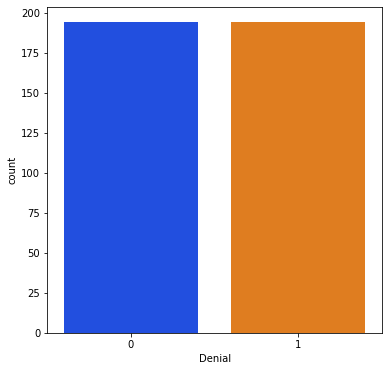

In [158]:
# Visualise target variable Churn 
y_smote = pd.DataFrame(y_sm, columns = ['Denial'])
# Target Varibale is now balanced
plt.figure(figsize=(6,6))
sns.countplot(x = 'Denial', data = y_smote, palette='bright')
# Percentage
# fraud = y_sm == 1
# y_true = y_sm[fraud]
# print("percent of fraud/no fraud (%):" +str((y_true.shape[0] / y_sm.shape[0] * 100)))
# Class is now balanced 

### Define functions to define and apply ML models 

### DT

In [19]:
# Function to perform nested CV on DT model 
def DT_nested(x_train, y_train):
    """pass x_train, y_train and function will perfrom nested CV on DT model to indicate how model may generalise"""
    
    clf = DecisionTreeClassifier()
    param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [2,4,6,8,10],
    'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 25}, 'balanced'] 
    }
    grid = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
    scores = cross_val_score(grid, x_train, y_train, cv=5)
    print('Average cross_val score of DT: %.4f' % scores.mean())

In [20]:
# Function to perform gridsearch and return optimal parameters 
def DT_grid(x_train, x_test, y_train, y_test):
    """pass x_train, X_test, y_train, y_test and function will perfrom gridsearch CV and return scores and print best params"""
    
    clf = DecisionTreeClassifier()
    param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [2,4,6,8,10],
    'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 25}, 'balanced'] 
    }
    grid = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
    grid.fit(x_train, y_train.values.ravel())
    
    # Mean cross-validated score of the best_estimator
    return print(" The best cross validation score for the DT model is: "  + np.str("%0.4f" % grid.best_score_) + 
                 "\n The best parameters for the DT model: " + np.str(grid.best_params_) + 
                 "\n Test score: {:.4f}".format(grid.score(x_test, y_test.values.ravel())))

In [21]:
# Function to provide evaulate optimal model on test data 
def DT_eval(x_train, x_test, y_train, y_test, criterion='entropy', max_depth=4, class_weight='balanced'):
    """Create confusion matrix. Pass best params manually from printed DT_grid function result"""
    clf=DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, class_weight=class_weight)
    clf.fit(x_train, y_train.values.ravel())
    DT_preds = clf.predict(x_test)
    DT_acc = clf.score(x_test, y_test.values.ravel())
    DT_cm = confusion_matrix(y_test, DT_preds)
    DT_precision, DT_recall, DT_f1score, _ = precision_recall_fscore_support(y_test, DT_preds, average='binary')
    DT_auc = roc_auc_score(y_test, DT_preds)
    return DT_acc, DT_cm, DT_precision, DT_recall, DT_f1score, DT_auc, DT_preds

### Random Forrest 

In [22]:
# Function to perform nested CV on RF model 
def RF_nested(x_train, y_train):
    """pass x_train, y_train and function will perfrom nested CV on RF model to indicate how model may generalise"""
    
    clf = RandomForestClassifier()
    param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [2,4,6,8,10],
    'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 25}, 'balanced'] 
    }
    grid = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
    scores = cross_val_score(grid, x_train, y_train, cv=5)
    print('Average cross_val score of RF: %.4f' % scores.mean())

In [25]:
# Function to perform gridsearch with CV and return optimal parameters 
def RF_grid(x_train, x_test, y_train, y_test):
    """pass x_train, X_test, y_train, y_test and function will perfrom gridsearch CV and return scores and print best params"""
    
    clf = RandomForestClassifier()
    param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [2,4,6,8,10],
    'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 25}, 'balanced'] 
    }
    grid = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
    grid.fit(x_train, y_train.values.ravel())
    
    # Mean cross-validated score of the best_estimator
    return print(" The best cross validation score for the RF model is: "  + np.str("%0.4f" % grid.best_score_) + 
                 "\n The best parameters for the RF model: " + np.str(grid.best_params_) + 
                 "\n Test score: {:.4f}".format(grid.score(x_test, y_test.values.ravel())))

In [26]:
# Function to evaulate optimised model on test data 
def RF_eval(x_train, x_test, y_train, y_test, criterion='gini', max_depth=6, class_weight={0: 1, 1: 5}):
    """Create confusion matrix. Pass best params manually from printed DT_grid function result"""
    clf=RandomForestClassifier(criterion=criterion, max_depth=max_depth, class_weight=class_weight)
    clf.fit(x_train, y_train.values.ravel())
    RF_preds = clf.predict(x_test)
    cm = confusion_matrix(y_test, RF_preds)
    RF_acc = clf.score(x_test, y_test.values.ravel())
    RF_cm = confusion_matrix(y_test, RF_preds)
    RF_precision, RF_recall, RF_f1score, _ = precision_recall_fscore_support(y_test, RF_preds, average='binary')
    RF_auc = roc_auc_score(y_test, RF_preds)
    return RF_acc, RF_cm, RF_precision, RF_recall, RF_f1score, RF_auc, RF_preds  

### SVM

In [27]:
# Function to perform nested CV with grid search on SVM to examine how the model will potentially generalise 
def SVM_nested(x,y):
    """Pass x,y and function performs nested CV with gridsearch with SVM"""
    clf = svm.SVC() # define model
    param_grid = {'C': [0.1,1,10,100],
                  'gamma': [1,0.1,0.01,0.001],
                  'class_weight': [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]}
    grid = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1) 
    scores = cross_val_score(grid, x_train, y_train.values.ravel(), cv=10) 
    # report performance
    return print('Average cross_val score of SVM: %.4f' % scores.mean())

In [28]:
# Function which performs gridsearch and returns scores and best params 
def SVM_grid(x_train, x_test, y_train, y_test):
    """Pass x_train, x_test, y_train, y_test"""
    
    clf = svm.SVC() # define model
    param_grid = {'C': [0.1,1,10,100, 500],
                  'gamma': [1,0.1,0.01,0.001],
                  'class_weight': [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]}
    grid = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1) 
    grid.fit(x_train, y_train.values.ravel()) # fit 
    
    # Mean cross-validated score of the best_estimator
    return print(" The best cross validation score for the SVM model is: "  + np.str("%0.4f" % grid.best_score_) + 
                 "\n The best parameters for the SVM model: " + np.str(grid.best_params_) + 
                 "\n Test score: {:.4f}".format(grid.score(x_test, y_test.values.ravel())))

In [29]:
# Function to evaluate cm of SVM on test data 
def SVM_eval(x_train, x_test, y_train, y_test, C = 0.1, class_weight= {0: 100, 1: 1}, gamma= 1):
    """pass x_train, x_test, y_train, y_test and best params manually from printed grid result"""
    clf = svm.SVC(C=C, gamma=gamma, class_weight = class_weight)
    clf.fit(x_train, y_train.values.ravel())
    SVM_preds = clf.predict(x_test)
    cm = confusion_matrix(y_test, SVM_preds)
    SVM_acc = clf.score(x_test, y_test.values.ravel())
    SVM_cm = confusion_matrix(y_test, SVM_preds)
    SVM_precision, SVM_recall, SVM_f1score, _ = precision_recall_fscore_support(y_test, SVM_preds, average='binary')
    SVM_auc = roc_auc_score(y_test, SVM_preds)
    return SVM_acc, SVM_cm, SVM_precision, SVM_recall, SVM_f1score, SVM_auc, SVM_preds  

### XGBoost 

In [149]:
# Function to perform nested grid search on XGB
def XGB_nested(x_train, y_train):
    """Takes x_train, y_train and performs nested grid search and return best score, indicates how model will generalise 
    to unseen data"""

    # Nested CV to indicate how well model will generalise to unseen data 
    clf = XGBClassifier(validate_parameters=True, objective="binary:logistic", silent=True, verbosity=0)
    param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
    }
#     param_grid = {'learning_rate': [0.0001,0.001,0.01,0.1,0.5,1], 
#                   'max_depth': [2,3,5,10,15,20],
#                  'scale_pos_weights': [1, 10, 25, 50, 75, 99, 100]}
    grid = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, scoring='roc_auc_ovr_weighted') 
    scores = cross_val_score(grid, x_train, y_train.values.ravel(), cv=5, scoring='roc_auc_ovr_weighted') 
    
    # report performance
    return print('Average cross_val score of SVM: %.4f' % scores.mean())

In [150]:
# Function for XGB evaluation 
def XGB_grid(x_train, x_test, y_train, y_test):
    """Takes x and y and performs grid search, returns CV score, best paras from grid search, score on test set,
    and confusion matrix"""
    
    clf = XGBClassifier(validate_parameters=True, objective="binary:logistic", silent=True, verbosity=0)
    
    # Hyper-tuner parameters and print results 
    param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
    }
#     param_grid = {'learning_rate': [0.0001,0.001,0.01,0.1,0.5,1], 
#                   'max_depth': [2,3,5,10,15,20],
#                  'scale_pos_weights': [1, 10, 25, 50, 75, 99, 100]}
    grid = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, scoring='roc_auc_ovr_weighted')
    grid.fit(x_train, y_train.values.ravel()) # fit 
    
    # # Mean cross-validated score of the best_estimator
    return print(" The best cross validation score with parameter tuning for the XGB model is: "  + np.str("%0.4f" % grid.best_score_) + 
                 "\n The best parameters for the XGB model: " + np.str(grid.best_params_) + 
                 "\n Test score: {:.4f}".format(grid.score(x_test, y_test.values.ravel())))

In [118]:
# Function to evaluate SVM on test data 
def XGB_eval(x_train, x_test, y_train, y_test, colsample_bytree = 0.5, gamma = 0, learning_rate=0.001, max_depth=3, 
             reg_lambda = 10, scale_pos_weight = 5, subsample = 0.8):
    """pass x_train, x_test, y_train, y_test and best params manually from printed grid result"""
    clf = XGBClassifier(validate_parameters=True, objective="binary:logistic", 
                        colsample_bytree = 0.5, gamma = 0,
                        learning_rate=learning_rate, max_depth=max_depth, reg_lambda=reg_lambda,
                        scale_pos_weight=scale_pos_weight, subsample=subsample, silent=True, verbosity=0)
    clf.fit(x_train, y_train.values.ravel())
    XGB_preds = clf.predict(x_test)
    cm = confusion_matrix(y_test, XGB_preds)
    XGB_acc = clf.score(x_test, y_test.values.ravel())
    XGB_cm = confusion_matrix(y_test, XGB_preds)
    XGB_precision, XGB_recall, XGB_f1score, _ = precision_recall_fscore_support(y_test, XGB_preds, average='binary')
    XGB_auc = roc_auc_score(y_test, XGB_preds)
    return XGB_acc, XGB_cm, XGB_precision, XGB_recall, XGB_f1score, XGB_auc, XGB_preds  

# Run functions and apply ML models to data and evaluate performance 

### DT

In [177]:
cols=col_names(df)
cols

Index(['Program Name', 'Is Secondary', 'Main Member Non-Diving',
       'State/Province', 'City', 'Country', 'Original Currency',
       'Insured State, Province, Territory, Canton etc.', 'Insured Country',
       'Location of loss Country', 'Cause of Loss Code', 'Denial',
       'Lloyd's Cat Code', 'Total days from policy taken to DOL',
       'Total days from DOL to claim made', 'Is DOL in policy period'],
      dtype='object')

In [182]:
# Split df in x, y, x_train, x_test, y_train, y_test
x, y, x_train, x_test, y_train, y_test = train_test(df)

In [35]:
# Perform gridsearchCV to establish best params and test score 
DT_grid(x_train, x_test, y_train, y_test)

 The best cross validation score for the DT model is: 0.7004
 The best parameters for the DT model: {'class_weight': {0: 1, 1: 1}, 'criterion': 'entropy', 'max_depth': 2}
 Test score: 0.7391


In [39]:
# Call the eval function manually inputting best aparams for clf and print evaluation results 
DT_acc, DT_cm, DT_precision, DT_recall, DT_f1score, DT_auc, DT_preds = DT_eval(x_train, 
                                                                               x_test, y_train, y_test, 
                                                                               criterion='entropy', max_depth=2, 
                                                                               class_weight={0: 1, 1: 1})
print("Accuracy:\t", "%0.4f" % DT_acc)
print("Precision:\t", "%0.4f" % DT_precision)
print("Recall:\t\t", "%0.4f" % DT_recall)
print("F1 Score:\t", "%0.4f" % DT_f1score)
print("AUC:\t\t", "%0.4f" % DT_auc)
DT_cm

Accuracy:	 0.7391
Precision:	 0.3333
Recall:		 0.0588
F1 Score:	 0.1000
AUC:		 0.5102


array([[50,  2],
       [16,  1]], dtype=int64)

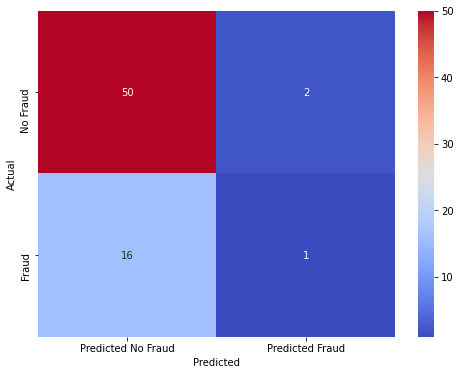

In [44]:
# Create confusion matrix 
con = confusion_matrix(y_test, DT_preds)
con
plt.figure(figsize=(8,6))
sns.heatmap(con, cmap="coolwarm", annot=True, fmt='g', xticklabels=('Predicted No Fraud', 'Predicted Fraud'), 
            yticklabels=('No Fraud', 'Fraud'))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Random Forrest 

In [93]:
# Perfomed nested CV on DT model 
RF_nested(x_train, y_train)

Average cross_val score of RF: 0.6789


In [94]:
# Perform gridsearchCV to establish best params and test score 
RF_grid(x_train, x_test, y_train, y_test)

 The best cross validation score for the RF model is: 0.7116
 The best parameters for the RF model: {'class_weight': {0: 1, 1: 1}, 'criterion': 'entropy', 'max_depth': 6}
 Test score: 0.7826


In [48]:
# Call the eval function manually inputting best aparams for clf and print evaluation results 
RF_acc, RF_cm, RF_precision, RF_recall, RF_f1score, RF_auc, RF_preds = RF_eval(x_train, 
                                                                               x_test, y_train, y_test, 
                                                                               criterion='entropy', max_depth=2, 
                                                                               class_weight={0: 1, 1: 1})
print("RF Accuracy:\t", "%0.4f" % RF_acc)
print("RF Precision:\t", "%0.4f" % RF_precision)
print("RF Recall:\t", "%0.4f" % RF_recall)
print("RF F1 Score:\t", "%0.4f" % RF_f1score)
print("RF AUC:\t\t", "%0.4f" % RF_auc)
RF4_cm

RF Accuracy:	 0.7536
RF Precision:	 0.0000
RF Recall:	 0.0000
RF F1 Score:	 0.0000
RF AUC:		 0.5000


array([[52,  0],
       [17,  0]], dtype=int64)

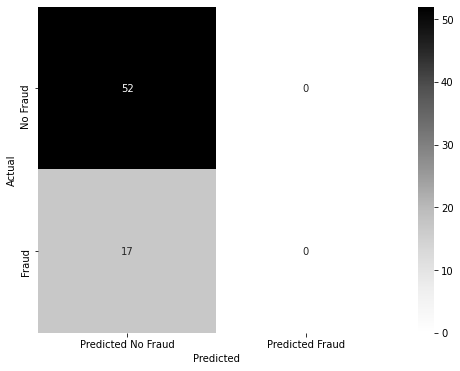

In [49]:
# Confusion matrix for RF
con = confusion_matrix(y_test, RF4_preds)
con
plt.figure(figsize=(8,6))
sns.heatmap(con, cmap="Greys", annot=True, fmt='g', xticklabels=('Predicted No Fraud', 'Predicted Fraud'), 
            yticklabels=('No Fraud', 'Fraud'))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### SVM

In [50]:
# Perfomed nested CV on SVM model 
SVM_nested(x_train, y_train)

Average cross_val score of SVM: 0.7115


In [51]:
# Perform gridsearchCV to establish best params and test score 
SVM_grid(x_train, x_test, y_train, y_test)

 The best cross validation score for the SVM model is: 0.7189
 The best parameters for the SVM model: {'C': 1, 'class_weight': {0: 1, 1: 1}, 'gamma': 0.001}
 Test score: 0.7536


In [52]:
# Call the eval function manually inputting best aparams for clf and print evaluation results 
SVM_acc, SVM_cm, SVM_precision, SVM_recall, SVM_f1score, SVM_auc, SVM_preds = SVM_eval(x_train, 
                                                                               x_test, y_train, y_test, 
                                                                               C = 1, class_weight= {0: 1, 1: 1}, 
                                                                                       gamma= 0.001)
print("SVM Accuracy:\t", "%0.4f" % SVM_acc)
print("SVM Precision:\t", "%0.4f" % SVM_precision)
print("SVM Recall:\t", "%0.4f" % SVM_recall)
print("SVM F1 Score:\t", "%0.4f" % SVM_f1score)
print("SVM AUC:\t", "%0.4f" % SVM_auc)
SVM_cm

SVM Accuracy:	 0.7536
SVM Precision:	 0.5000
SVM Recall:	 0.1176
SVM F1 Score:	 0.1905
SVM AUC:	 0.5396


array([[50,  2],
       [15,  2]], dtype=int64)

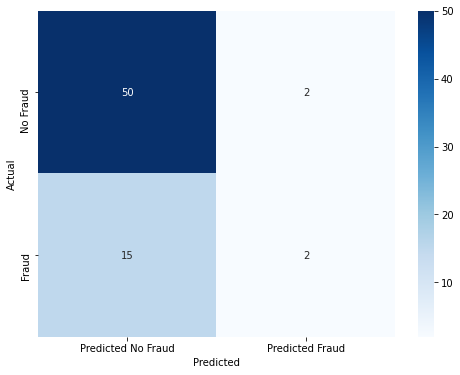

In [53]:
# Confusion matrix for SVM
con = confusion_matrix(y_test, SVM_preds)
con
plt.figure(figsize=(8,6))
sns.heatmap(con, cmap="Blues", annot=True, fmt='g', xticklabels=('Predicted No Fraud', 'Predicted Fraud'), 
            yticklabels=('No Fraud', 'Fraud'))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### XGBoost 

In [184]:
# Perform nested CV on XGB model 
XGB_nested(x_train, y_train)

Average cross_val score of SVM: 0.5725


In [186]:
# Perform gridsearchCV to establish best params and test score 
XGB_grid(x_train, x_test, y_train, y_test)

 The best cross validation score with parameter tuning for the XGB model is: 0.6197
 The best parameters for the XGB model: {'colsample_bytree': 0.5, 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'reg_lambda': 0, 'scale_pos_weight': 3, 'subsample': 0.8}
 Test score: 0.6369


In [187]:
# Call the eval function manually inputting best aparams for clf and print evaluation results 
XGB_acc, XGB_cm, XGB_precision, XGB_recall, XGB_f1score, XGB_auc, XGB_preds = XGB_eval(x_train, 
                                                                               x_test, y_train, y_test, 
                                                                               colsample_bytree = 0.5, gamma = 0.25,
                                                                               learning_rate = 0.01, max_depth = 7,
                                                                               reg_lambda = 0, scale_pos_weight = 3,        
                                                                               subsample = 0.8)
print("XGB Accuracy:\t", "%0.4f" % XGB_acc)
print("XGB Precision:\t", "%0.4f" % XGB_precision)
print("XGB Recall:\t", "%0.4f" % XGB_recall)
print("XGB F1 Score:\t", "%0.4f" % XGB_f1score)
print("XGB AUC:\t", "%0.4f" % XGB_auc)
XGB_cm

XGB Accuracy:	 0.7101
XGB Precision:	 0.4211
XGB Recall:	 0.4706
XGB F1 Score:	 0.4444
XGB AUC:	 0.6295


array([[41, 11],
       [ 9,  8]], dtype=int64)

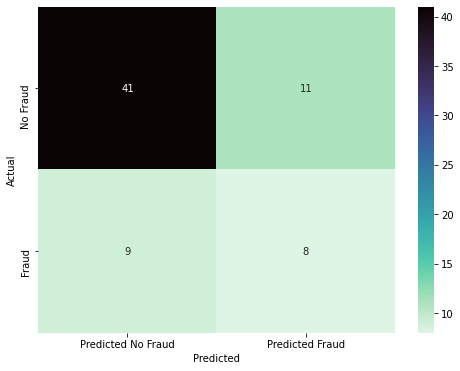

In [700]:
# Confusion matrix for XGB
con = confusion_matrix(y_test, XGB_preds)
con
plt.figure(figsize=(8,6))
sns.heatmap(con, cmap="mako_r", annot=True, fmt='g', xticklabels=('Predicted No Fraud', 'Predicted Fraud'), 
            yticklabels=('No Fraud', 'Fraud'))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [180]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# df_s = scaler.fit_transform(df)